In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

# Self driving car model analysis

The purpose of this analysis is try to explain the train and test proceses. Analysing data and augmentation this to improve accurary and later simulation over udacity simulator.

Without further ado, let's start with the step-by-step process:

**Step 1**: Let's import required classes & functions:

In [15]:
import os
from IPython.display import Image

from lib.config import Config
from lib.dataset_loader import DatasetLoader
from lib.model_factory import ModelFactory
from lib.plot_utils import show_img, graph_model, show_nvidia_model_topology, show_model

from keras import backend as K

**Step 2**: Frist of all check that has a GPU available. This is required to decrease learning training times: 

In [3]:
print("Available GPU's: ", K.tensorflow_backend._get_available_gpus())

Available GPU's:  ['/job:localhost/replica:0/task:0/device:GPU:0']


**Step 3**: Load config file.

In [4]:
cfg = Config('./config.yml')

**Step 4**: Load dataset.

In [5]:
loader = DatasetLoader(cfg)

dataset = loader.load(
    features=cfg['dataset']['features'],
    labels=cfg['dataset']['labels']
)

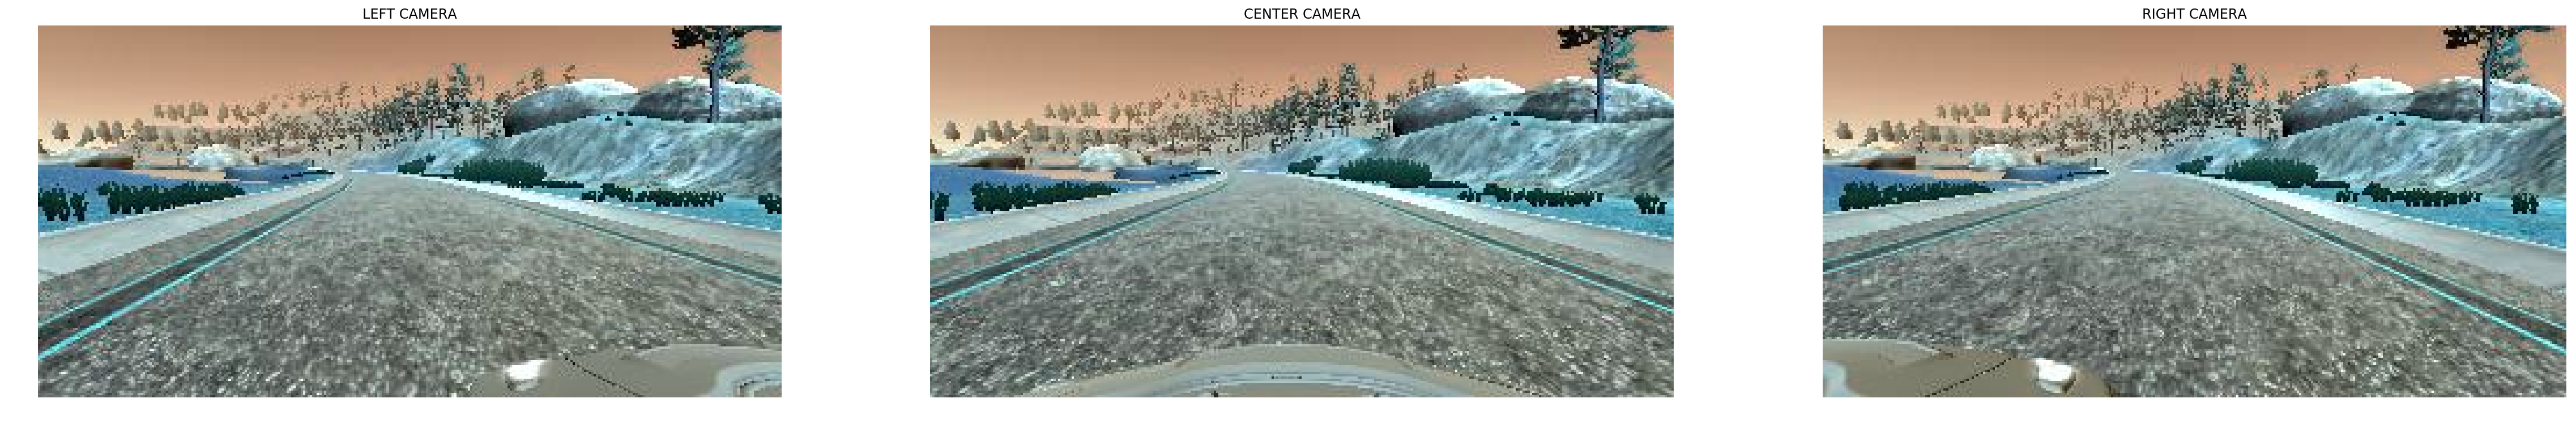

Steering Angle:  0.0


In [6]:
example = dataset[0]
example.show()

**Step 5**: Split dataset in train and validation.

In [7]:
train_dataset, validation_dataset = dataset.split(percent=cfg['train']['validation_set_percent'])

In [8]:
print("Train dataset examples: ", len(train_dataset))

Train dataset examples:  651


In [9]:
print("Validation dataset examples: ", len(validation_dataset))

Validation dataset examples:  163


**Step 5**: Create Nvidia CNN Model.




MODEL SUMMARY

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_11 (Lambda)           (None, 160, 320, 3)       0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 78, 158, 24)       1824      
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 37, 77, 36)        21636     
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 17, 37, 48)        43248     
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 15, 35, 64)        27712     
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 13, 33, 64)        36928     
_________________________________________________________________
dropout_11 (Dropout)         (None, 13, 33, 64)        0  

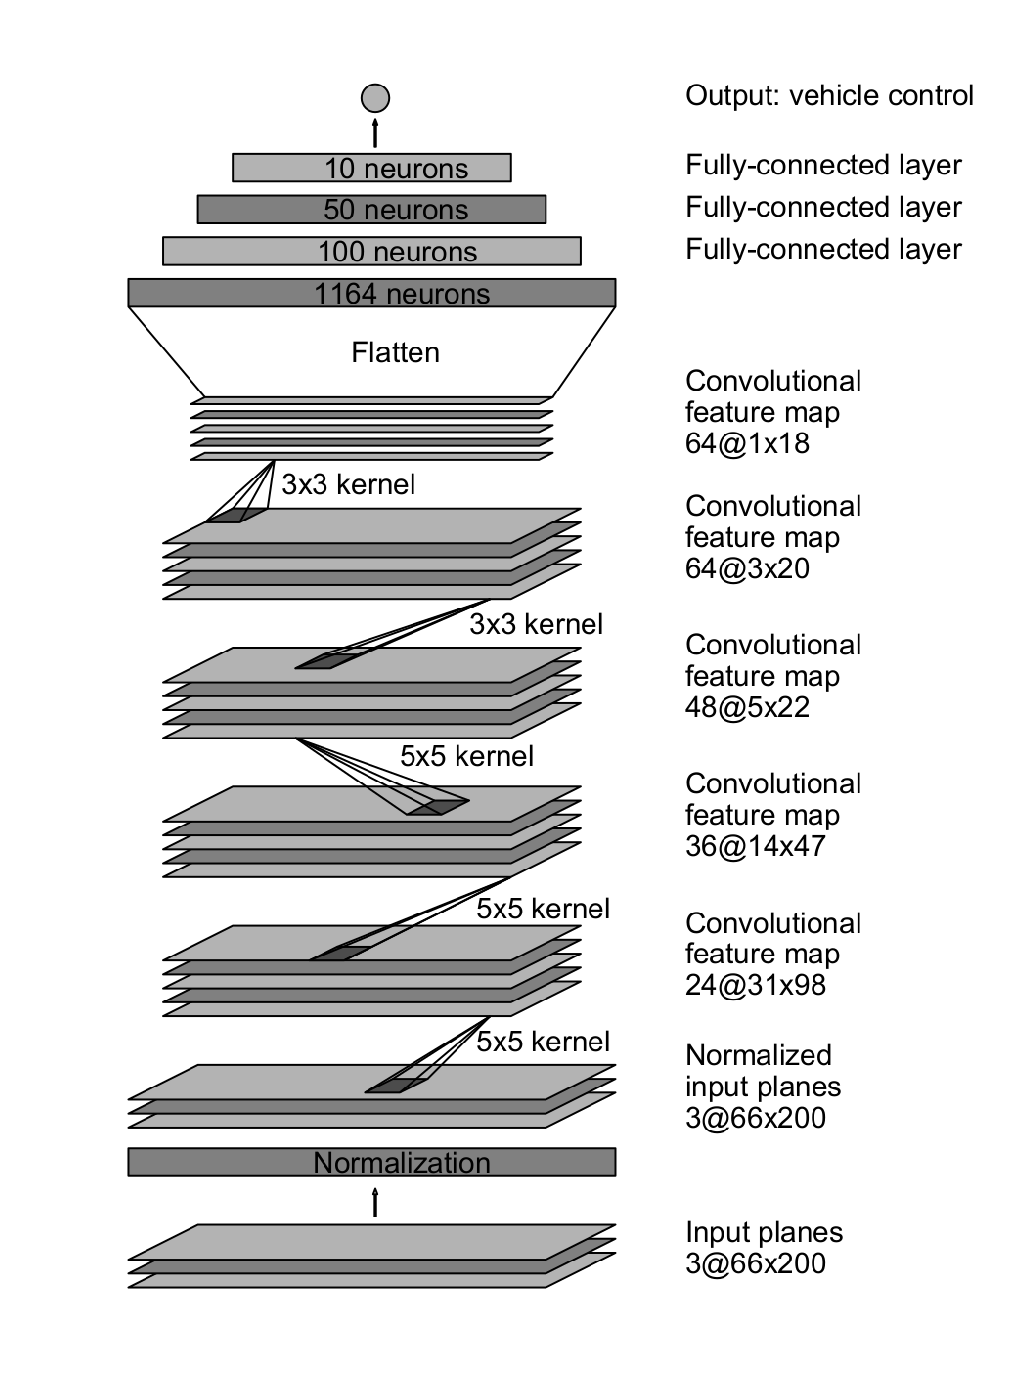

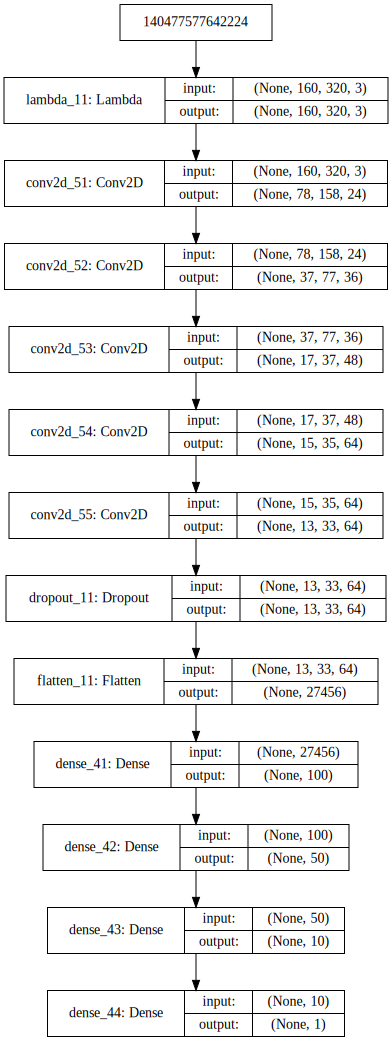

In [26]:
model = ModelFactory.create_nvidia_model()
model.show()